In [28]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional, Dropout, GlobalMaxPool1D, BatchNormalization
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [29]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/customer-support-intent-dataset/Bitext_Sample_Customer_Service_Training_Dataset.csv
/kaggle/input/customer-support-intent-dataset/Bitext_Sample_Customer_Service_Validation_Dataset.csv
/kaggle/input/customer-support-intent-dataset/Bitext_Sample_Customer_Service_Testing_Dataset.csv


In [30]:
train = pd.read_csv("/kaggle/input/customer-support-intent-dataset/Bitext_Sample_Customer_Service_Training_Dataset.csv")
validation = pd.read_csv("/kaggle/input/customer-support-intent-dataset/Bitext_Sample_Customer_Service_Validation_Dataset.csv")
test = pd.read_csv("/kaggle/input/customer-support-intent-dataset/Bitext_Sample_Customer_Service_Testing_Dataset.csv")


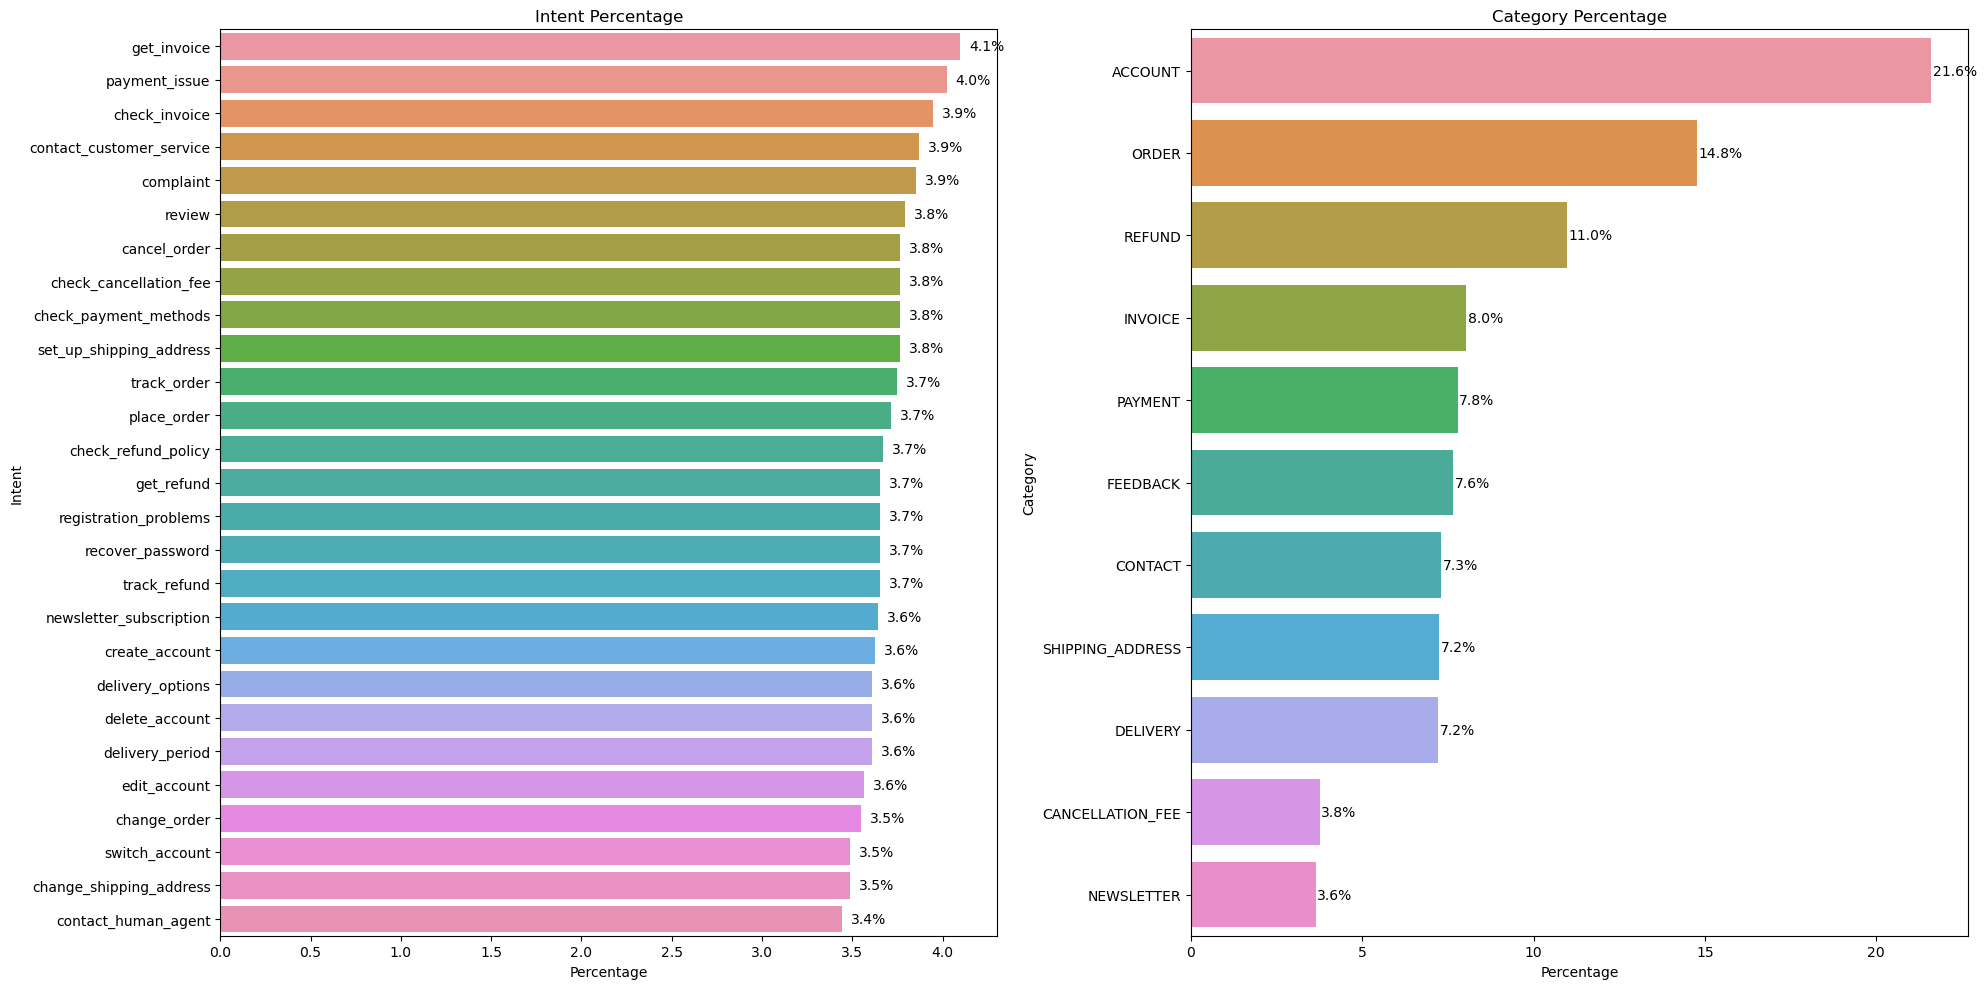

In [31]:
# Calculate the percentages for each column
intent_percentages = train['intent'].value_counts(normalize=True) * 100
category_percentages = train['category'].value_counts(normalize=True) * 100

# Create the horizontal bar plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.barplot(x=intent_percentages.values, y=intent_percentages.index, ax=axes[0])
sns.barplot(x=category_percentages.values, y=category_percentages.index, ax=axes[1])

# Add percentages to the bars
for i, v in enumerate(intent_percentages.values):
    axes[0].text(v+0.05, i, f'{v:.1f}%', color='black', va='center')
for i, v in enumerate(category_percentages.values):
    axes[1].text(v+0.05, i, f'{v:.1f}%', color='black', va='center')
# Add labels and titles

axes[0].set_title('Intent Percentage')
axes[0].set_xlabel('Percentage')
axes[0].set_ylabel('Intent')
axes[1].set_title('Category Percentage')
axes[1].set_xlabel('Percentage')
axes[1].set_ylabel('Category')

# Show the plot
plt.tight_layout()
plt.show()

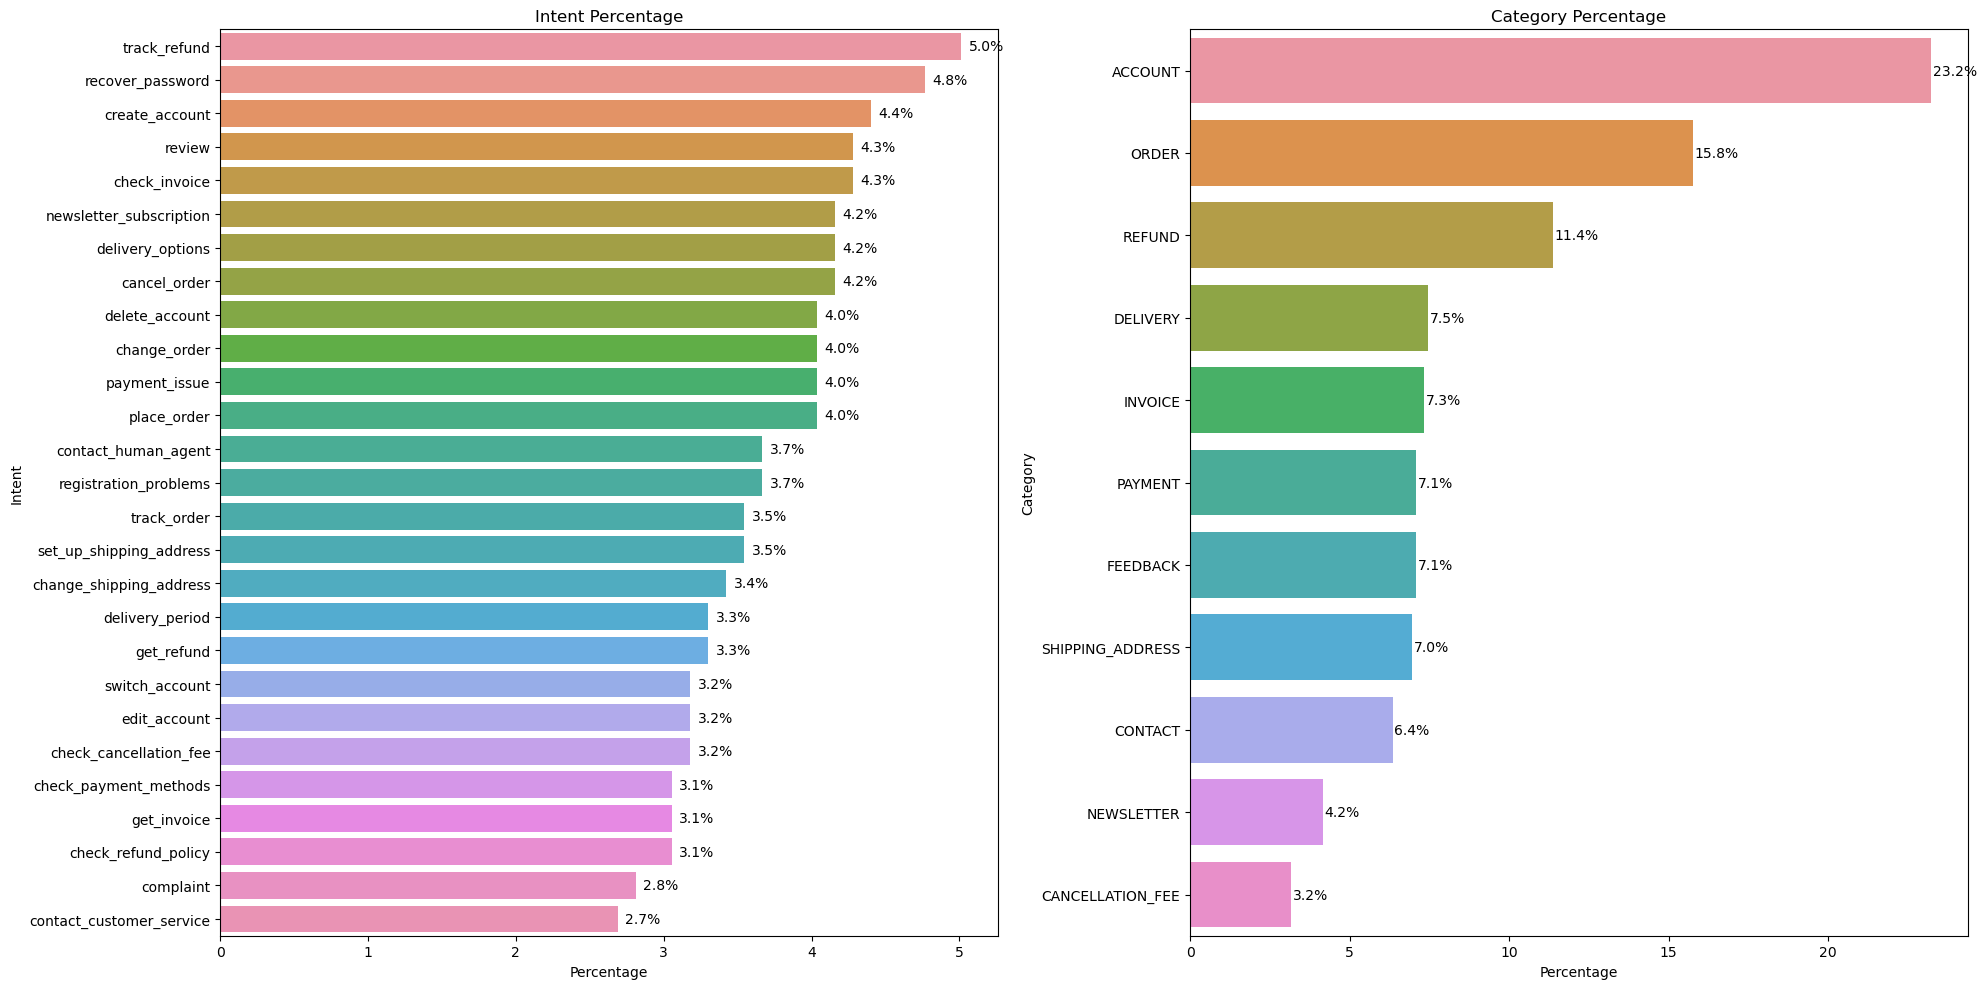

In [32]:
# Calculate the percentages for each column
intent_percentages = validation['intent'].value_counts(normalize=True) * 100
category_percentages = validation['category'].value_counts(normalize=True) * 100

# Create the horizontal bar plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.barplot(x=intent_percentages.values, y=intent_percentages.index, ax=axes[0])
sns.barplot(x=category_percentages.values, y=category_percentages.index, ax=axes[1])

# Add percentages to the bars
for i, v in enumerate(intent_percentages.values):
    axes[0].text(v+0.05, i, f'{v:.1f}%', color='black', va='center')
for i, v in enumerate(category_percentages.values):
    axes[1].text(v+0.05, i, f'{v:.1f}%', color='black', va='center')

# Add labels and titles
axes[0].set_title('Intent Percentage')
axes[0].set_xlabel('Percentage')
axes[0].set_ylabel('Intent')
axes[1].set_title('Category Percentage')
axes[1].set_xlabel('Percentage')
axes[1].set_ylabel('Category')

# Show the plot
plt.tight_layout()
plt.show()

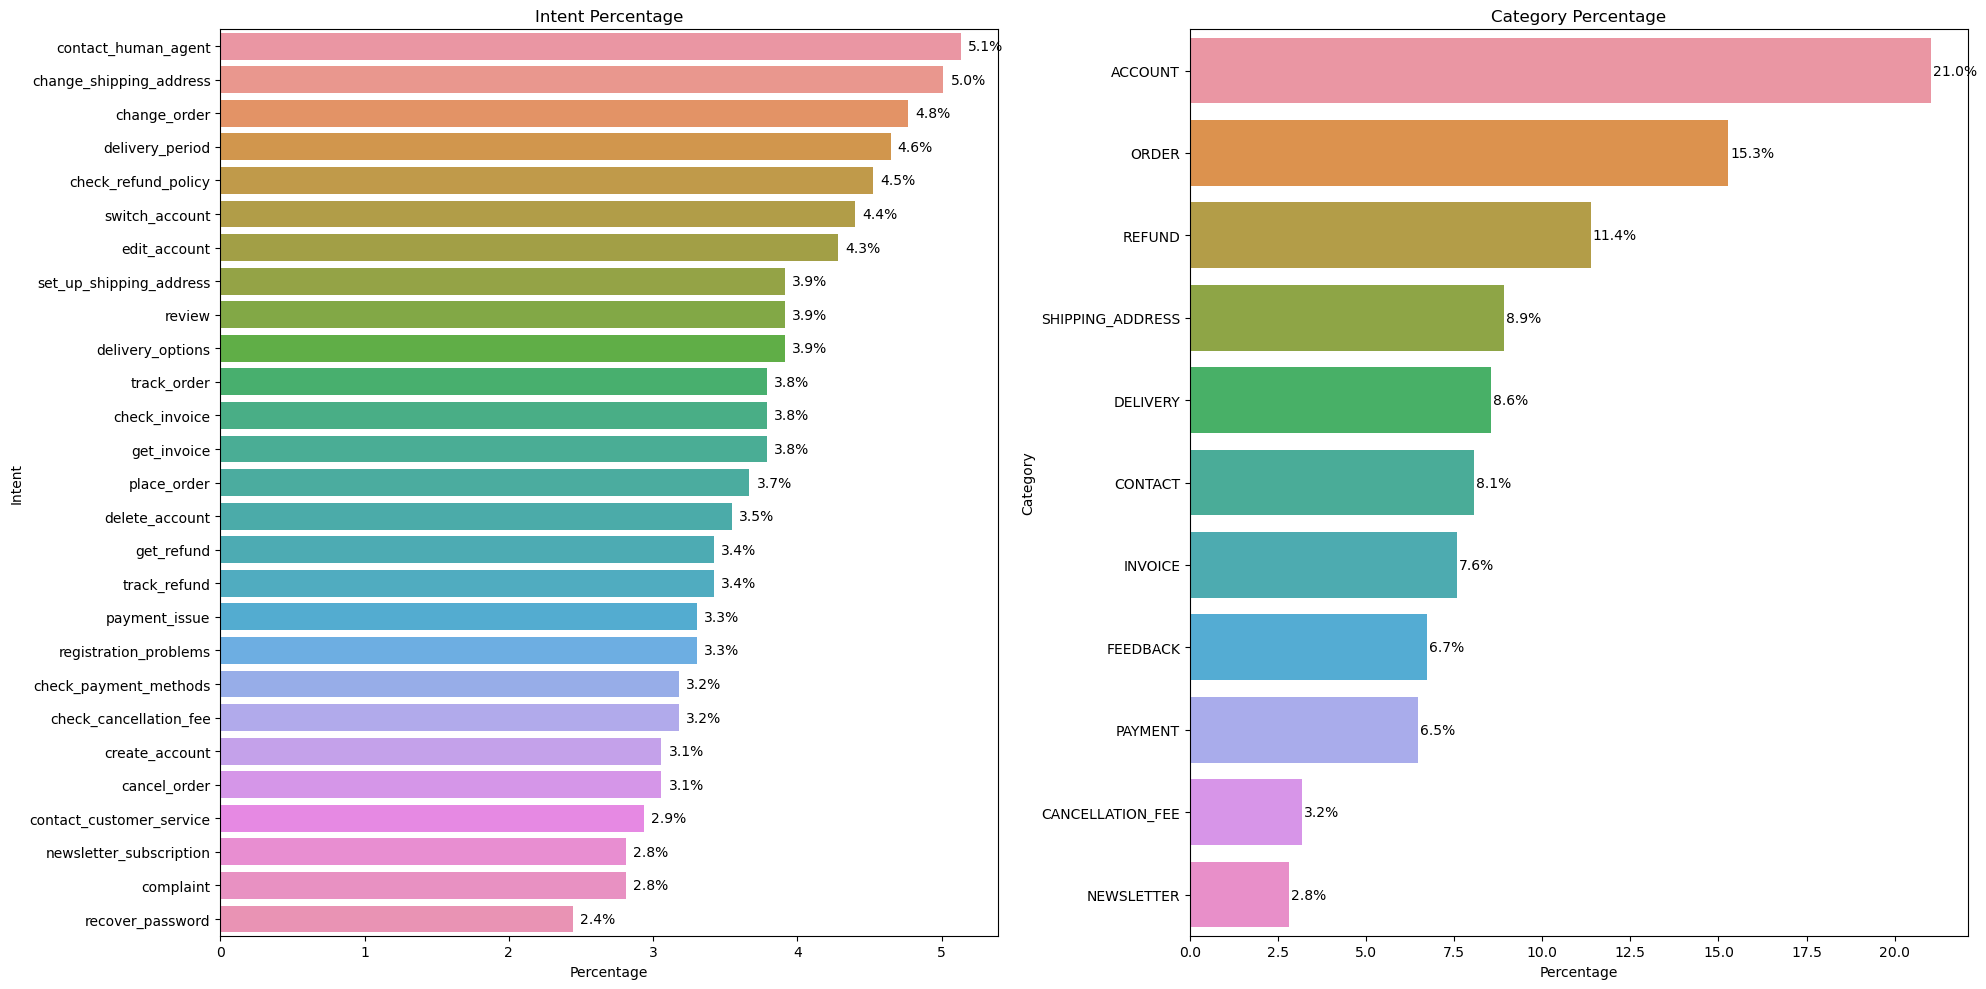

In [33]:
# Calculate the percentages for each column

intent_percentages = test['intent'].value_counts(normalize=True) * 100
category_percentages = test['category'].value_counts(normalize=True) * 100

# Create the horizontal bar plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.barplot(x=intent_percentages.values, y=intent_percentages.index, ax=axes[0])
sns.barplot(x=category_percentages.values, y=category_percentages.index, ax=axes[1])

# Add percentages to the bars
for i, v in enumerate(intent_percentages.values):
    axes[0].text(v+0.05, i, f'{v:.1f}%', color='black', va='center')
for i, v in enumerate(category_percentages.values):
    axes[1].text(v+0.05, i, f'{v:.1f}%', color='black', va='center')

# Add labels and titles
axes[0].set_title('Intent Percentage')
axes[0].set_xlabel('Percentage')
axes[0].set_ylabel('Intent')
axes[1].set_title('Category Percentage')
axes[1].set_xlabel('Percentage')
axes[1].set_ylabel('Category')

# Show the plot
plt.tight_layout()
plt.show()

In [47]:
# Combine the DataFrames into a list
data_frames = [train, test, validation]

# Perform Label Encoding for each DataFrame in the list
le = LabelEncoder()
for df in data_frames:
    le.fit(df['intent'])
    df['intent'] = le.transform(df['intent'])

# Splitting to features and target
X_train, X_test , X_validation = train['utterance'] , test['utterance'], validation['utterance']
y_train, y_test , y_validation = train['intent'] , test['intent'], validation['intent']
# Convert the text data into sequences of integer values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_validation_sequences = tokenizer.texts_to_sequences(X_validation)

# Pad the sequences to ensure they all have the same length
maxlen = 100
X_train_padded = pad_sequences(X_train_sequences, padding='post', truncating='post', maxlen=maxlen)
X_validation_padded = pad_sequences(X_validation_sequences, padding='post', truncating='post', maxlen=maxlen)

# Load the pre-trained GloVe embeddings
word_vectors = api.load('glove-wiki-gigaword-100')

# Create the embedding layer
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_vector = word_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)

In [50]:
num_classes = train['intent'].nunique()
# Define the LSTM model
model = Sequential()
model.add(embedding_layer)
    
model.add(Bidirectional(LSTM(
        100, 
        return_sequences = True, 
        recurrent_dropout=0.2)))  
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation = "relu"))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_data=(X_validation_padded, y_validation))

Epoch 1/20
103/103 [==============================] - 39s 300ms/step - loss: 3.1152 - accuracy: 0.0973 - val_loss: 3.0591 - val_accuracy: 0.3386
Epoch 2/20
103/103 [==============================] - 30s 287ms/step - loss: 1.9262 - accuracy: 0.3669 - val_loss: 2.0676 - val_accuracy: 0.5880
Epoch 3/20
103/103 [==============================] - 29s 281ms/step - loss: 1.1856 - accuracy: 0.5683 - val_loss: 1.0101 - val_accuracy: 0.8447
Epoch 4/20
103/103 [==============================] - 29s 283ms/step - loss: 0.8751 - accuracy: 0.6763 - val_loss: 0.4918 - val_accuracy: 0.8753
Epoch 5/20
103/103 [==============================] - 30s 286ms/step - loss: 0.6985 - accuracy: 0.7399 - val_loss: 0.2810 - val_accuracy: 0.9156
Epoch 6/20
103/103 [==============================] - 31s 302ms/step - loss: 0.6016 - accuracy: 0.7809 - val_loss: 0.1662 - val_accuracy: 0.9352
Epoch 7/20
103/103 [==============================] - 32s 308ms/step - loss: 0.4851 - accuracy: 0.8205 - val_loss: 0.1408 - val_ac

In [54]:
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, padding='post', truncating='post', maxlen=maxlen)

In [55]:
# Model Evaluation on the test set
model.evaluate(X_test_padded,y_test)

26/26 [==============================] - 1s 46ms/step - loss: 0.0445 - accuracy: 0.9878


[0.044461533427238464, 0.9877750873565674]

26/26 [==============================] - 1s 52ms/step


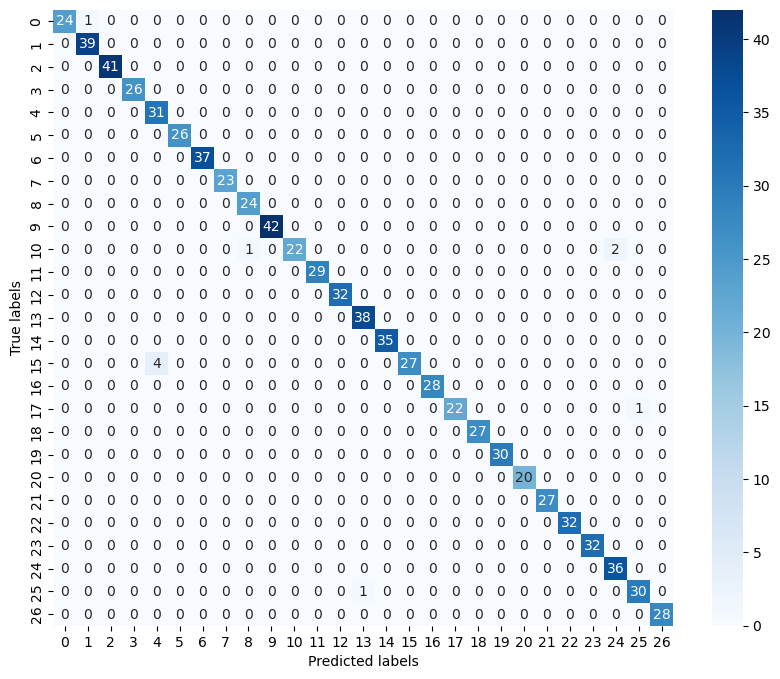

In [65]:
# Making predictions on the test set 
predicted_labels = np.argmax(model.predict(X_test_padded), axis=-1)

# Create the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [72]:
# Save the model in HDF5 format
model.save('/kaggle/working/intent_model.h5')